In [ ]:
!python  -V

In [156]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

In [3]:
!which python

/home/ubuntu/anaconda3/bin/python


In [4]:
# !pip install pyarrow
# !pip install scikit-learn

In [97]:
def read_df(filename):
    df = pd.read_parquet(filename)
    df['duration']= df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60.0)
    df = df[(df.duration <= 60) & (df.duration >= 1)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    df ['PU_DO'] =  df['PULocationID'] + '_' + df['DOLocationID']    
    return(df)

In [98]:
df = read_df('./data/green_tripdata_2021-01.parquet')

In [99]:
df_val = read_df('./data/green_tripdata_2021-02.parquet')

In [100]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
PU_DO                            object
dtype: object

In [101]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75


In [102]:
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
count,73908.000000,73908,73908,38175.000000,38175.000000,73908.00000,73908.000000,73908.000000,73908.000000,73908.000000,73908.000000,73908.000000,73908.000000,38175.000000,38175.000000,38175.000000,73908.000000
mean,1.905477,2021-01-16 17:21:32.747754,2021-01-16 17:38:23.902459,1.082384,1.196123,42.04772,19.516128,0.755601,0.253044,1.509278,0.516947,0.298981,23.146646,1.403248,1.016765,0.644479,16.852578
min,1.000000,2009-01-01 00:03:25,2009-01-01 00:12:25,1.000000,0.000000,0.00000,-280.000000,-5.500000,-0.500000,-9.450000,0.000000,-0.300000,-280.300000,1.000000,1.000000,0.000000,1.000000
25%,2.000000,2021-01-08 23:58:27.250000,2021-01-09 00:09:25.500000,1.000000,1.000000,1.34000,9.000000,0.000000,0.000000,0.000000,0.000000,0.300000,12.000000,1.000000,1.000000,0.000000,8.050000
50%,2.000000,2021-01-16 10:21:55.500000,2021-01-16 10:36:41,1.000000,1.000000,2.60000,16.830000,0.000000,0.500000,1.260000,0.000000,0.300000,20.640000,1.000000,1.000000,0.000000,14.000000
75%,2.000000,2021-01-24 09:52:04.500000,2021-01-24 10:06:39,1.000000,1.000000,5.68000,25.210000,1.000000,0.500000,2.750000,0.000000,0.300000,29.000000,2.000000,1.000000,0.000000,22.633333
max,2.000000,2021-01-31 23:46:45,2021-01-31 23:57:08,5.000000,6.000000,244152.01000,280.000000,8.250000,0.500000,110.000000,31.250000,0.300000,280.300000,5.000000,2.000000,2.750000,60.000000
std,0.292557,NaN,NaN,0.563789,0.762638,1958.08235,13.456264,1.194225,0.250780,1.774129,1.801223,0.021572,14.806009,0.506995,0.128391,1.164868,11.563163


In [103]:
df['duration']

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [104]:
# df['duration']

/tmp/ipykernel_18532/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

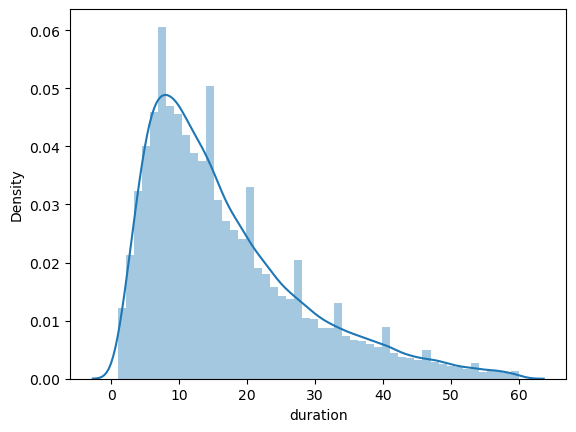

In [105]:
sns.distplot(df.duration)

In [106]:
df.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [107]:
df.duration.describe(percentiles=[0.02, 0.05, 0.5, 0.95, 0.98])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
2%           2.550000
5%           3.816667
50%         14.000000
95%         41.000000
98%         48.781000
max         60.000000
Name: duration, dtype: float64

In [108]:
((df.duration <= 60) & (df.duration >= 1)).mean()

np.float64(1.0)

In [109]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration', 'PU_DO'],
      dtype='object')

In [110]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [111]:
# df ['PU_DO'] =  df['PULocationID'] + '_' + df['DOLocationID']

In [112]:
categorical = ['PU_DO']

In [142]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

# [In 51] Initialize and Fit/Transform the DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [143]:
# train_dicts

In [144]:
y_train = df[target].values

In [145]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# [In 51] Initialize and Fit/Transform the DictVectorizer
X_val = dv.transform(val_dicts)
y_val = df_val[target].values

In [146]:
# dv.feature_names_

In [147]:
# train_dicts
# X_train

In [148]:
lr = LinearRegression()

In [149]:
lr.fit(X_train, y_train)

LinearRegression()

In [150]:
X_train.shape

(73908, 13221)

In [151]:
# X_train

In [152]:
y_pred = lr.predict(X_val)

/tmp/ipykernel_18532/1221023267.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = 'training data')
/tmp/ipykernel_18532/1221023267.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')


<Axes: ylabel='Density'>

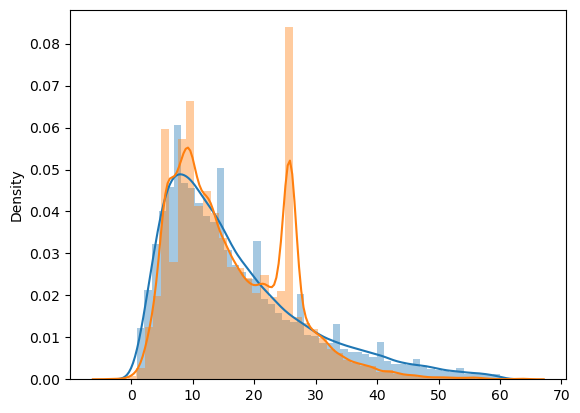

In [153]:
sns.distplot(y_train, label = 'training data')
sns.distplot(y_pred, label = 'prediction')

In [155]:
import numpy as np
print(np.sqrt(mean_squared_error(y_val,y_pred)))

7.758715206128955


In [159]:
with open('models/lin_reg-bin', "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [161]:
print(1)

1
